<a href="https://colab.research.google.com/github/maxmatical/gld_forecasting/blob/master/GLD_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git
!pip install scikit-optimize
!install pyro-ppl 
!pip install --upgrade ta

In [2]:
!git clone https://github.com/maxmatical/gld_forecasting.git


Cloning into 'gld_forecasting'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [10]:
%cd /content/gld_forecasting
!ls

/content/gld_forecasting
GLD.csv  lookahead.py  radam.py  ranger.py  README.md


In [4]:
# Set up environment and download course-v3
# !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ta
from fastai import *
from fastai.tabular import * 
from fastai.utils.show_install import *
from fastai.callbacks import *
show_install()




```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61.dev0
fastprogress  : 0.2.2
torch         : 1.3.1
nvidia driver : 418.67
torch cuda    : 10.1.243 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-ru

In [29]:
df = pd.read_csv('./GLD.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
1,2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2,2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
3,2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
4,2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


# Experiment 1: FE + MLP

In [30]:
# adding technical indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume")

/usr/local/lib/python3.6/dist-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [31]:
df.head(5).T

,0,1,2,3,4
Date,2004-11-18,2004-11-19,2004-11-22,2004-11-23,2004-11-24
Open,44.43,44.49,44.75,44.88,44.93
High,44.49,44.92,44.97,44.92,45.05
Low,44.07,44.47,44.74,44.72,44.79
Close,44.38,44.78,44.95,44.75,45.05
...,...,...,...,...,...
momentum_kama,NaN,NaN,NaN,NaN,NaN
momentum_roc,NaN,NaN,NaN,NaN,NaN
others_dr,-59.5181,0.901302,0.379638,-0.444941,0.670389
others_dlr,NaN,0.897265,0.378919,-0.445934,0.668152


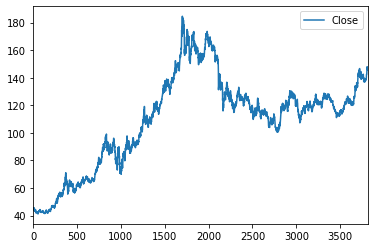

In [32]:
plt.figure(); df['Close'].plot(); plt.legend(loc='best')

In [0]:
# adding lag values
def add_lag(df, cols, lag):
    """
    add lag values up to lag
    """
    for c in cols:
        for i in range(1,lag+1): # 1 to lag value
            df[f'{c}_lag_{i}'] = df[c].shift(i)

    return df

In [34]:
df = add_lag(df, ['Open', 'High', 'Low', 'Close', 'Volume'], 7)
df.head(5).T

,0,1,2,3,4
Date,2004-11-18,2004-11-19,2004-11-22,2004-11-23,2004-11-24
Open,44.43,44.49,44.75,44.88,44.93
High,44.49,44.92,44.97,44.92,45.05
Low,44.07,44.47,44.74,44.72,44.79
Close,44.38,44.78,44.95,44.75,45.05
...,...,...,...,...,...
Volume_lag_3,NaN,NaN,NaN,5.992e+06,1.16553e+07
Volume_lag_4,NaN,NaN,NaN,NaN,5.992e+06
Volume_lag_5,NaN,NaN,NaN,NaN,NaN
Volume_lag_6,NaN,NaN,NaN,NaN,NaN
